In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [35]:
df_sentiment = pd.read_csv("./Topic Modelling per Sentence/The_Kingmaker/sentence_sentiment_results.csv")
df_reviews = pd.read_csv("./Sentiment Analysis CSV/the_kingmaker_reviews_sentiment.csv")

In [36]:
emotion_map = {'positive': 1, 'negative': -1}
df_sentiment['emotion'] = df_sentiment['sentiment_label'].map(emotion_map).fillna(0)

df_sentiment['x'] = df_sentiment['sentiment_score'] * df_sentiment['emotion']

results_df = df_sentiment.groupby('review_index').agg(
    sum_score=('x', 'sum'),
    num_sentences=('sentence_index', 'count')
).reset_index()

results_df['avg_sentiment'] = 50 + abs(50 / results_df['num_sentences'] * results_df['sum_score'])

# Merge avg_sentiment into df_sentiment and rename it to nmd_score
df_sentiment = df_sentiment.merge(
    results_df[['review_index', 'avg_sentiment', 'num_sentences']], 
    on='review_index', 
    how='left'
)

# Rename 'avg_sentiment' to 'nmd_score' to match what you want
df_sentiment = df_sentiment.rename(columns={'avg_sentiment': 'nmd_score'})

# Prepare reviews data
df_reviews = df_reviews.rename(columns={'review_id': 'review_index', 'sentence_num': 'sentence_num_original'})
df_reviews['sentence_index'] = df_reviews['sentence_num_original'] - 1

# Merge the two dataframes
df_combined = pd.merge(
    df_sentiment,
    df_reviews[['review_index', 'sentence_index', 'username', 'date', 'rating', 'source']],
    on=['review_index', 'sentence_index'],
    how='inner'
)

# Create a summary dataframe with one row per review
review_summary = df_combined.groupby('review_index').agg({
    'username': 'first',
    'date': 'first',
    'rating': 'first',
    'source': 'first',
    'nmd_score': 'first',
    'num_sentences': 'first'  # This already exists from the merge
}).reset_index()

# Rename columns for clarity
review_summary = review_summary.rename(columns={
    'rating': 'user_rating',
    'date': 'review_date'
})

# Add the original metrics from results_df
review_summary = review_summary.merge(
    results_df[['review_index', 'sum_score']],
    on='review_index',
    how='left'
)

# Calculate additional metrics from sentiment data
sentiment_stats = df_sentiment.groupby('review_index').agg({
    'sentiment_score': 'mean',
    'sentiment_label': lambda x: (x == 'positive').mean() * 100
}).reset_index()

sentiment_stats = sentiment_stats.rename(columns={
    'sentiment_score': 'avg_sentiment_score',
    'sentiment_label': 'positive_percentage'
})

# Merge the sentiment stats
review_summary = review_summary.merge(sentiment_stats, on='review_index', how='left')

# Reorder columns for better presentation
review_summary = review_summary[[
    'review_index', 'username', 'review_date', 'user_rating', 'source',
    'num_sentences', 'sum_score', 'nmd_score', 
    'avg_sentiment_score', 'positive_percentage'
]]

print("\n" + "="*80)
print("COMBINED REVIEW SUMMARY (one row per review):")
print("="*80)
print(review_summary.to_string())

print("\n" + "="*80)
print("DETAILED COMBINED DATA (all sentences):")
print("="*80)
print(df_combined[['review_index', 'sentence_index', 'username', 'date', 
                   'rating', 'source', 'sentiment_label', 'sentiment_score', 
                   'nmd_score', 'sentence_text']].head(10).to_string())

# Verification
print("\n" + "="*80)
print("FORMULA VERIFICATION FOR FIRST REVIEW:")
print("="*80)
first_review = review_summary.iloc[0]
print(f"Review Index: {first_review['review_index']}")
print(f"sum_score: {first_review['sum_score']:.6f}")
print(f"num_sentences: {first_review['num_sentences']}")
print(f"Manual calculation: 100/{first_review['num_sentences']} × {first_review['sum_score']:.6f}")
print(f"  = {100/first_review['num_sentences']} × {first_review['sum_score']:.6f}")
print(f"  = {100/first_review['num_sentences'] * first_review['sum_score']:.6f}")
print(f"nmd_score in DataFrame: {first_review['nmd_score']:.6f}")


COMBINED REVIEW SUMMARY (one row per review):
      review_index                    username              review_date  user_rating source  num_sentences  sum_score  nmd_score  avg_sentiment_score  positive_percentage
0                0                   VoNiTo101  2022-05-06 00:00:00.000         90.0   imdb              5   2.939009  79.390088             0.845795            80.000000
1                1                    brockfal  2022-05-10 00:00:00.000         80.0   imdb              5   1.180802  61.808017             0.828601            60.000000
2                2             DennisGillEndor  2019-12-05 00:00:00.000         90.0   imdb              4   2.108930  76.361625             0.841766            75.000000
3                3         andrewcollins-86653  2021-10-29 00:00:00.000        100.0   imdb              4   2.187481  77.343507             0.901964            75.000000
4                4                     wmurch3  2022-06-08 00:00:00.000        100.0   imdb       

In [37]:
import os

# Create the directory if it doesn't exist
output_dir = './Narrative-Metric Disconnect/The Kingmaker'
os.makedirs(output_dir, exist_ok=True)

# Export the two main dataframes
review_summary.to_csv(os.path.join(output_dir, 'review_summary.csv'), index=False)
df_combined.to_csv(os.path.join(output_dir, 'detailed_sentiment_data.csv'), index=False)

print(f"Files exported to: {output_dir}")
print(f"1. review_summary.csv ({len(review_summary)} reviews)")
print(f"2. detailed_sentiment_data.csv ({len(df_combined)} sentences)")

Files exported to: ./Narrative-Metric Disconnect/The Kingmaker
1. review_summary.csv (1464 reviews)
2. detailed_sentiment_data.csv (4277 sentences)


In [38]:
df_nmd = pd.read_csv("./Narrative-Metric Disconnect/The Kingmaker/detailed_sentiment_data.csv")

Creating line charts with raised y-axis maximum values...


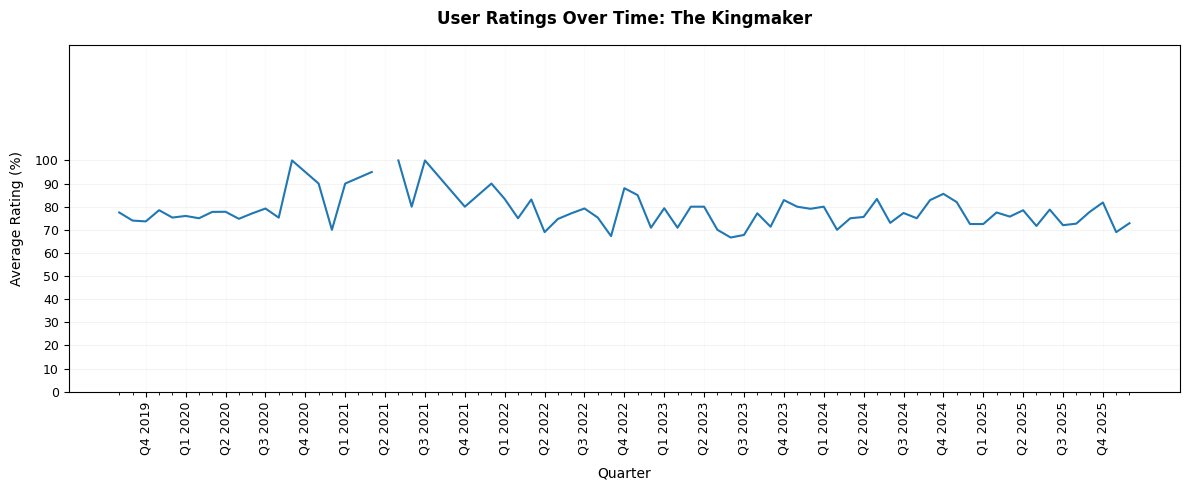


User Ratings Timeline for 'The Kingmaker':
Time period: Aug 2019 to Dec 2025
Overall average: 76.4%
Y-axis range: 0 to 100%


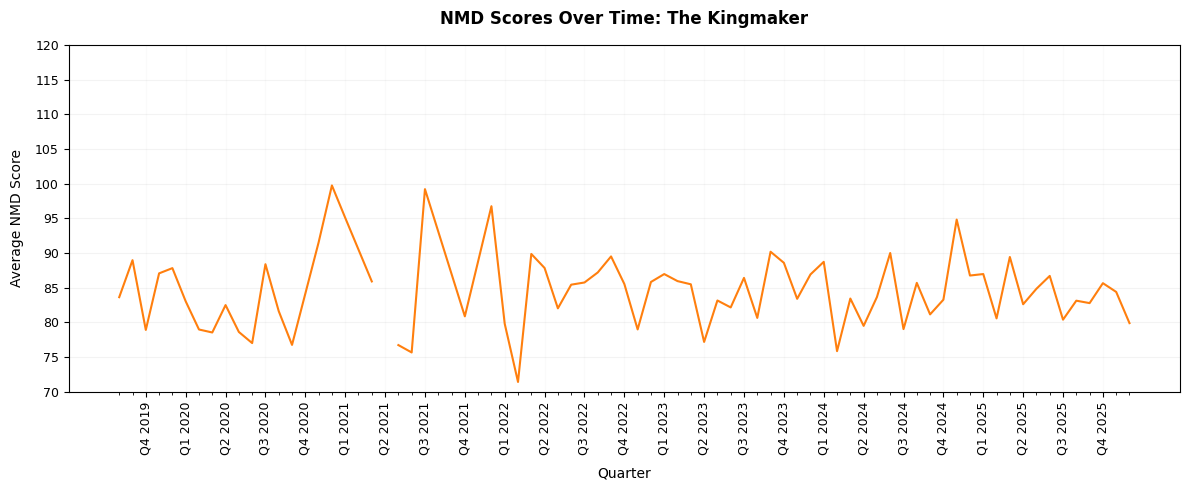


NMD Scores Timeline for 'The Kingmaker':
Time period: Aug 2019 to Dec 2025
Overall average: 83.15
Y-axis range: 0.0 to 1.0


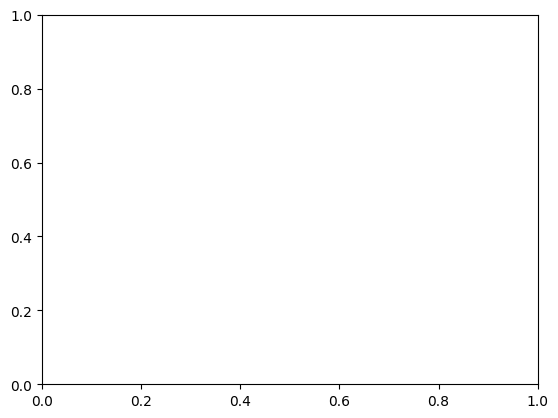

In [ ]:
def create_rating_line_graph(df, movie_name):
    """
    Create a simple line graph showing user ratings over time (by month)
    Based on the provided template design
    """
    # Ensure date is datetime
    if 'review_date' in df.columns:
        df['date'] = df['review_date']
    
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by month and calculate average rating
    df['month'] = df['date'].dt.to_period('M')
    ratings_by_month = df.groupby('month')['user_rating'].mean()
    
    # Convert to dataframe for plotting
    ratings_by_month_df = ratings_by_month.reset_index()
    ratings_by_month_df.columns = ['month', 'avg_rating']
    
    # Convert period to datetime for better formatting
    ratings_by_month_df['month_datetime'] = ratings_by_month_df['month'].dt.to_timestamp()
    
    # Create a complete date range from min to max month
    if len(ratings_by_month_df) > 0:
        min_date = ratings_by_month_df['month_datetime'].min()
        max_date = ratings_by_month_df['month_datetime'].max()
        
        # Generate all months between min and max
        all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
        all_months_period = all_months.to_period('M')
        
        # Create a dataframe with all months
        all_months_df = pd.DataFrame({
            'month': all_months_period,
            'month_datetime': all_months
        })
        
        # Merge with actual data, filling missing months with NaN
        complete_df = pd.merge(all_months_df, ratings_by_month_df, 
                              on=['month', 'month_datetime'], 
                              how='left')
        
        # Update ratings_by_month_df to include all months
        ratings_by_month_df = complete_df
    
    # Create formatted month names
    ratings_by_month_df['month_name'] = ratings_by_month_df['month_datetime'].dt.strftime('%b %Y')
    ratings_by_month_df['year'] = ratings_by_month_df['month_datetime'].dt.year
    ratings_by_month_df['month_num'] = ratings_by_month_df['month_datetime'].dt.month
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Plot WITHOUT markers (dots) - just the line
    x_positions = range(len(ratings_by_month_df))
    
    # Create a copy for plotting that connects gaps
    plot_data = ratings_by_month_df['avg_rating'].copy()
    
    # For better visualization, interpolate small gaps (1-2 months)
    # But keep larger gaps as breaks in the line
    plot_data_interpolated = plot_data.copy()
    
    # Find consecutive NaN sequences
    mask = plot_data.isna()
    groups = (~mask).cumsum()
    group_sizes = groups.map(groups.value_counts())
    
    # Interpolate small gaps (1-2 months)
    small_gaps = (mask) & (group_sizes <= 2)
    if small_gaps.any():
        plot_data_interpolated = plot_data_interpolated.interpolate(method='linear', limit=2)
    
    # Plot the line - this will automatically break at NaN values
    plt.plot(x_positions, 
             plot_data_interpolated, 
             marker='o',
             linestyle='-',
             linewidth=1.5,
             markersize=0,
             markeredgewidth=0,
             color='#1f77b4')
    
    # Determine x-axis label display
    num_months = len(ratings_by_month_df)
    
    if num_months > 12:
        # Create quarterly labels
        quarterly_positions = []
        quarterly_labels = []
        
        # Get unique years sorted
        years = sorted(ratings_by_month_df['year'].unique())
        
        for year in years:
            # For each year, show Q1, Q2, Q3, Q4 at quarter starts (Jan, Apr, Jul, Oct)
            year_data = ratings_by_month_df[ratings_by_month_df['year'] == year]
            
            # Find positions for each quarter start
            for quarter, start_month in enumerate([1, 4, 7, 10], 1):
                quarter_data = year_data[year_data['month_num'] == start_month]
                if not quarter_data.empty:
                    idx = quarter_data.index[0]
                    quarterly_positions.append(idx)
                    quarterly_labels.append(f"Q{quarter} {year}")
        
        # Check if the last two labels are the same
        if len(quarterly_labels) >= 2:
            # Check if last two labels are the same quarter/year
            last_label = quarterly_labels[-1]
            second_last_label = quarterly_labels[-2]
            
            # If they're the same, remove the last one
            if last_label == second_last_label:
                quarterly_positions = quarterly_positions[:-1]
                quarterly_labels = quarterly_labels[:-1]
        
        # Only add last position if it's not already included AND it's different from existing
        last_idx = len(ratings_by_month_df) - 1
        if last_idx not in quarterly_positions and len(quarterly_positions) > 0:
            last_row = ratings_by_month_df.iloc[-1]
            last_year = last_row['year']
            last_month = last_row['month_num']
            
            if last_month <= 3:
                last_quarter = 1
            elif last_month <= 6:
                last_quarter = 2
            elif last_month <= 9:
                last_quarter = 3
            else:
                last_quarter = 4
            
            last_quarter_label = f"Q{last_quarter} {last_year}"
            
            # Check if this label is different from the last existing label
            if not quarterly_labels or last_quarter_label != quarterly_labels[-1]:
                quarterly_positions.append(last_idx)
                quarterly_labels.append(last_quarter_label)
        
        # Set x-ticks
        ax = plt.gca()
        ax.set_xticks(quarterly_positions)
        ax.set_xticklabels(quarterly_labels, rotation=90, ha='center', fontsize=9)
        
        # Set minor ticks for all positions to maintain x-grid
        ax.set_xticks(x_positions, minor=True)
        
    else:
        # Show all months for 12 months or fewer
        plt.xticks(x_positions, ratings_by_month_df['month_name'], 
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis for ratings - SIMPLE FIX: RAISE THE MAX VALUE
    # Always use 0-100 range for ratings (since they're percentages)
    plt.ylim(0, 110)
    
    # Set y-ticks from 0 to 100 with step of 10
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add a subtle zero line
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Title and labels
    plt.title(f'User Ratings Over Time: {movie_name}', fontsize=12, fontweight='bold', pad=15)
    plt.xlabel('Quarter' if num_months > 12 else 'Month', fontsize=10, labelpad=8)
    plt.ylabel('Average Rating (%)', fontsize=10, labelpad=8)
    
    # Grid and layout
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.05, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nUser Ratings Timeline for '{movie_name}':")
    print(f"Time period: {ratings_by_month_df['month_name'].iloc[0]} to {ratings_by_month_df['month_name'].iloc[-1]}")
    print(f"Overall average: {df['user_rating'].mean():.1f}%")
    print(f"Y-axis range: 0 to 100%")


def create_nmd_line_graph(df, movie_name):
    """
    Create a simple line graph showing NMD scores over time (by month)
    Based on the provided template design
    """
    # Ensure date is datetime
    if 'review_date' in df.columns:
        df['date'] = df['review_date']
    
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by month and calculate average NMD
    df['month'] = df['date'].dt.to_period('M')
    nmd_by_month = df.groupby('month')['nmd_score'].mean()
    
    # Convert to dataframe for plotting
    nmd_by_month_df = nmd_by_month.reset_index()
    nmd_by_month_df.columns = ['month', 'avg_nmd']
    
    # Convert period to datetime for better formatting
    nmd_by_month_df['month_datetime'] = nmd_by_month_df['month'].dt.to_timestamp()
    
    # Create a complete date range from min to max month
    if len(nmd_by_month_df) > 0:
        min_date = nmd_by_month_df['month_datetime'].min()
        max_date = nmd_by_month_df['month_datetime'].max()
        
        # Generate all months between min and max
        all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
        all_months_period = all_months.to_period('M')
        
        # Create a dataframe with all months
        all_months_df = pd.DataFrame({
            'month': all_months_period,
            'month_datetime': all_months
        })
        
        # Merge with actual data, filling missing months with NaN
        complete_df = pd.merge(all_months_df, nmd_by_month_df, 
                              on=['month', 'month_datetime'], 
                              how='left')
        
        # Update nmd_by_month_df to include all months
        nmd_by_month_df = complete_df
    
    # Create formatted month names
    nmd_by_month_df['month_name'] = nmd_by_month_df['month_datetime'].dt.strftime('%b %Y')
    nmd_by_month_df['year'] = nmd_by_month_df['month_datetime'].dt.year
    nmd_by_month_df['month_num'] = nmd_by_month_df['month_datetime'].dt.month
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Plot WITHOUT markers (dots) - just the line
    x_positions = range(len(nmd_by_month_df))
    
    # Create a copy for plotting that connects gaps
    plot_data = nmd_by_month_df['avg_nmd'].copy()
    
    # For better visualization, interpolate small gaps (1-2 months)
    plot_data_interpolated = plot_data.copy()
    
    # Find consecutive NaN sequences
    mask = plot_data.isna()
    groups = (~mask).cumsum()
    group_sizes = groups.map(groups.value_counts())
    
    # Interpolate small gaps (1-2 months)
    small_gaps = (mask) & (group_sizes <= 2)
    if small_gaps.any():
        plot_data_interpolated = plot_data_interpolated.interpolate(method='linear', limit=2)
    
    # Plot the line - this will automatically break at NaN values
    plt.plot(x_positions, 
             plot_data_interpolated, 
             marker='o',
             linestyle='-',
             linewidth=1.5,
             markersize=0,
             markeredgewidth=0,
             color='#ff7f0e')  # Orange color for NMD
    
    # Determine x-axis label display
    num_months = len(nmd_by_month_df)
    
    if num_months > 12:
        # Create quarterly labels
        quarterly_positions = []
        quarterly_labels = []
        
        # Get unique years sorted
        years = sorted(nmd_by_month_df['year'].unique())
        
        for year in years:
            # For each year, show Q1, Q2, Q3, Q4 at quarter starts (Jan, Apr, Jul, Oct)
            year_data = nmd_by_month_df[nmd_by_month_df['year'] == year]
            
            # Find positions for each quarter start
            for quarter, start_month in enumerate([1, 4, 7, 10], 1):
                quarter_data = year_data[year_data['month_num'] == start_month]
                if not quarter_data.empty:
                    idx = quarter_data.index[0]
                    quarterly_positions.append(idx)
                    quarterly_labels.append(f"Q{quarter} {year}")
        
        # Check if the last two labels are the same
        if len(quarterly_labels) >= 2:
            # Check if last two labels are the same quarter/year
            last_label = quarterly_labels[-1]
            second_last_label = quarterly_labels[-2]
            
            # If they're the same, remove the last one
            if last_label == second_last_label:
                quarterly_positions = quarterly_positions[:-1]
                quarterly_labels = quarterly_labels[:-1]
        
        # Only add last position if it's not already included AND it's different from existing
        last_idx = len(nmd_by_month_df) - 1
        if last_idx not in quarterly_positions and len(quarterly_positions) > 0:
            last_row = nmd_by_month_df.iloc[-1]
            last_year = last_row['year']
            last_month = last_row['month_num']
            
            if last_month <= 3:
                last_quarter = 1
            elif last_month <= 6:
                last_quarter = 2
            elif last_month <= 9:
                last_quarter = 3
            else:
                last_quarter = 4
            
            last_quarter_label = f"Q{last_quarter} {last_year}"
            
            # Check if this label is different from the last existing label
            if not quarterly_labels or last_quarter_label != quarterly_labels[-1]:
                quarterly_positions.append(last_idx)
                quarterly_labels.append(last_quarter_label)
        
        # Set x-ticks
        ax = plt.gca()
        ax.set_xticks(quarterly_positions)
        ax.set_xticklabels(quarterly_labels, rotation=90, ha='center', fontsize=9)
        
        # Set minor ticks for all positions to maintain x-grid
        ax.set_xticks(x_positions, minor=True)
        
    else:
        # Show all months for 12 months or fewer
        plt.xticks(x_positions, nmd_by_month_df['month_name'], 
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis for NMD scores - SIMPLE: RAISE THE MAX VALUE
    valid_nmd = nmd_by_month_df['avg_nmd'].dropna()
    
    if len(valid_nmd) > 0:
        # Get min and max values
        y_min = max(0, valid_nmd.min())
        y_max = valid_nmd.max()
        
        # SIMPLE FIX: RAISE THE MAX VALUE by adding a fixed amount
        # Option 1: Add 20% to the max
        y_max = y_max * 1.20
        
        # Option 2: Or use a fixed high value if you want more space
        # y_max = max(y_max, 100)  # At least 100
        
        # Set the y-axis limits
        plt.ylim(y_min, y_max)
        
        # Create nice y-ticks
        y_range = y_max - y_min
        if y_range <= 10:
            step = 1
        elif y_range <= 20:
            step = 2
        elif y_range <= 50:
            step = 5
        else:
            step = 10
        
        # Generate y-ticks
        start_tick = np.floor(y_min / step) * step
        end_tick = np.ceil(y_max / step) * step
        y_ticks = np.arange(start_tick, end_tick + step, step)
        
        plt.yticks(y_ticks, fontsize=9)
        
    else:
        # Default range if no valid data
        plt.ylim(0, 10)
        y_ticks = list(range(0, 11, 1))
        plt.yticks(y_ticks, fontsize=9)
    
    # Add a subtle zero line
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Title and labels
    plt.title(f'NMD Scores Over Time: {movie_name}', fontsize=12, fontweight='bold', pad=15)
    plt.xlabel('Quarter' if num_months > 12 else 'Month', fontsize=10, labelpad=8)
    plt.ylabel('Average NMD Score', fontsize=10, labelpad=8)
    
    # Grid and layout
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.05, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nNMD Scores Timeline for '{movie_name}':")
    print(f"Time period: {nmd_by_month_df['month_name'].iloc[0]} to {nmd_by_month_df['month_name'].iloc[-1]}")
    print(f"Overall average: {df['nmd_score'].mean():.2f}")
    print(f"Y-axis range: {plt.gca().get_ylim()[0]:.1f} to {plt.gca().get_ylim()[1]:.1f}")


# Create both charts
print("Creating line charts with raised y-axis maximum values...")

# Ensure we have the date column in review_summary
if 'review_date' in review_summary.columns:
    review_summary = review_summary.rename(columns={'review_date': 'date'})
elif 'date' not in review_summary.columns:
    # Check for alternative date columns
    for col in ['Date', 'DATE', 'review_date', 'Review_Date']:
        if col in review_summary.columns:
            review_summary = review_summary.rename(columns={col: 'date'})
            break

# Create ratings chart (with fixed 0-100 range)
create_rating_line_graph(review_summary.copy(), "The Kingmaker")

# Create NMD chart (with raised max)
create_nmd_line_graph(review_summary.copy(), "The Kingmaker")